In [1]:
import sys
import os
import copy 
import configparser
import numpy as np
import torch

cur_dir = ''
sys.path.append(os.path.join(cur_dir,'utils'))
from data_loader import WeaveSpectraDatasetInference
from training_utils import str2bool
from network import StarNet, build_starnet, load_model_state
from analysis_fns import plot_progress, predict_labels, predict_ensemble, plot_resid, plot_one_to_one

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Using Torch version: %s' % (torch.__version__))
print('Using a %s device' % (device))

model_name = 'starnet_ss_1'

# Directories
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
data_dir = os.path.join(cur_dir, 'data/')

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
    
# TRAINING PARAMETERS
source_data_file = os.path.join(data_dir, config['DATA']['source_data_file'])
target_data_file = os.path.join(data_dir, config['DATA']['target_data_file'])
wave_grid_file = os.path.join(data_dir, config['DATA']['wave_grid_file'])
label_keys = eval(config['DATA']['label_keys'])
normalize_spectra = str2bool(config['DATA']['normalize_spectra'])
split_channels = str2bool(config['DATA']['split_channels'])
random_chunk = str2bool(config['DATA']['random_chunk'])

# Build network
model = build_starnet(config, device, model_name)

# Load model state from previous training
model_filename =  os.path.join(model_dir, model_name+'.pth.tar')
model, losses, cur_iter = load_model_state(model, model_filename)

# Create dataset for loading spectra
source_train_dataset = WeaveSpectraDatasetInference(source_data_file, 
                                           dataset='train', 
                                           wave_grid_file=wave_grid_file, 
                                           label_keys=label_keys,
                                           normalize_spectra=normalize_spectra,
                                                    split_channels=split_channels,
                                           num_fluxes=model.num_fluxes, 
                                           tasks=model.tasks, 
                                           task_means=model.task_means.cpu().numpy(), 
                                           task_stds=model.task_stds.cpu().numpy(),
                                           median_thresh=0., std_min=0.01,
                                           random_chunk=random_chunk)

source_val_dataset = WeaveSpectraDatasetInference(source_data_file, 
                                         dataset='val', 
                                         wave_grid_file=wave_grid_file, 
                                         label_keys=label_keys,
                                         normalize_spectra=normalize_spectra,
                                                    split_channels=split_channels, 
                                         num_fluxes=model.num_fluxes, 
                                         tasks=model.tasks, 
                                         task_means=model.task_means.cpu().numpy(), 
                                         task_stds=model.task_stds.cpu().numpy(),
                                         median_thresh=0., std_min=0.01,
                                           random_chunk=random_chunk)

target_train_dataset = WeaveSpectraDatasetInference(target_data_file, 
                                           dataset='train', 
                                           wave_grid_file=wave_grid_file, 
                                           label_keys=label_keys,
                                           normalize_spectra=normalize_spectra, 
                                                    split_channels=split_channels,
                                           num_fluxes=model.num_fluxes,
                                           tasks=model.tasks, 
                                           task_means=model.task_means.cpu().numpy(), 
                                           task_stds=model.task_stds.cpu().numpy(),
                                           median_thresh=0., std_min=0.01,
                                           random_chunk=random_chunk)

target_val_dataset = WeaveSpectraDatasetInference(target_data_file, 
                                         dataset='val', 
                                         wave_grid_file=wave_grid_file, 
                                         label_keys=label_keys,
                                         normalize_spectra=normalize_spectra,
                                                    split_channels=split_channels, 
                                         num_fluxes=model.num_fluxes,
                                         tasks=model.tasks, 
                                         task_means=model.task_means.cpu().numpy(), 
                                         task_stds=model.task_stds.cpu().numpy(),
                                         median_thresh=0., std_min=0.01,
                                           random_chunk=random_chunk)

print('The source training set consists of %i spectra.' % (len(source_train_dataset)))
print('The source validation set consists of %i spectra.' % (len(source_val_dataset)))

print('The target training set consists of %i spectra.' % (len(target_train_dataset)))
print('The target validation set consists of %i spectra.' % (len(target_val_dataset)))

Using Torch version: 1.13.1+cu117
Using a cpu device

Creating model: starnet_ss_1

Configuration:
  DATA
    source_data_file: ambre_ss_suppnet_normed.h5
    target_data_file: golden_sample_ss_suppnet_normed.h5
    wave_grid_file: weave_hr_wavegrid_arms.npy
    label_keys: ['teff', 'feh', 'logg', 'alpha', 'vrad']
    normalize_spectra: False
    split_channels: True
    add_noise_to_source: True
    random_chunk: True
    overlap: 0.5
  TRAINING
    batchsize: 8
    lr_warmup: 5000
    min_lr: 0.01
    min_lr_iters: 600000
    total_batch_iters: 2000000
    source_task_weights: [0.1, 0.05, 0.05, 0.1]
    target_task_weights: [0.1, 0.05, 0.05, 0.1]
  ARCHITECTURE
    spectrum_size: 43480
    num_fluxes: 6000
    encoder_dim: 18
    conv_filts: [64, 64, 32, 32, 16]
    conv_strides: [4,2,2,2,2]
    filter_lengths: [15, 15, 7, 7, 7]
    pool_length: 0
    num_hidden: [64, 32]
    label_means: [5800, -1, 3.0, 0.2, 0]
    label_stds: [1200, 1.6, 1.4, 0.3, 50]
    spectra_mean: 0.9
    spec

### **Display training progress**

starnet_ss_1


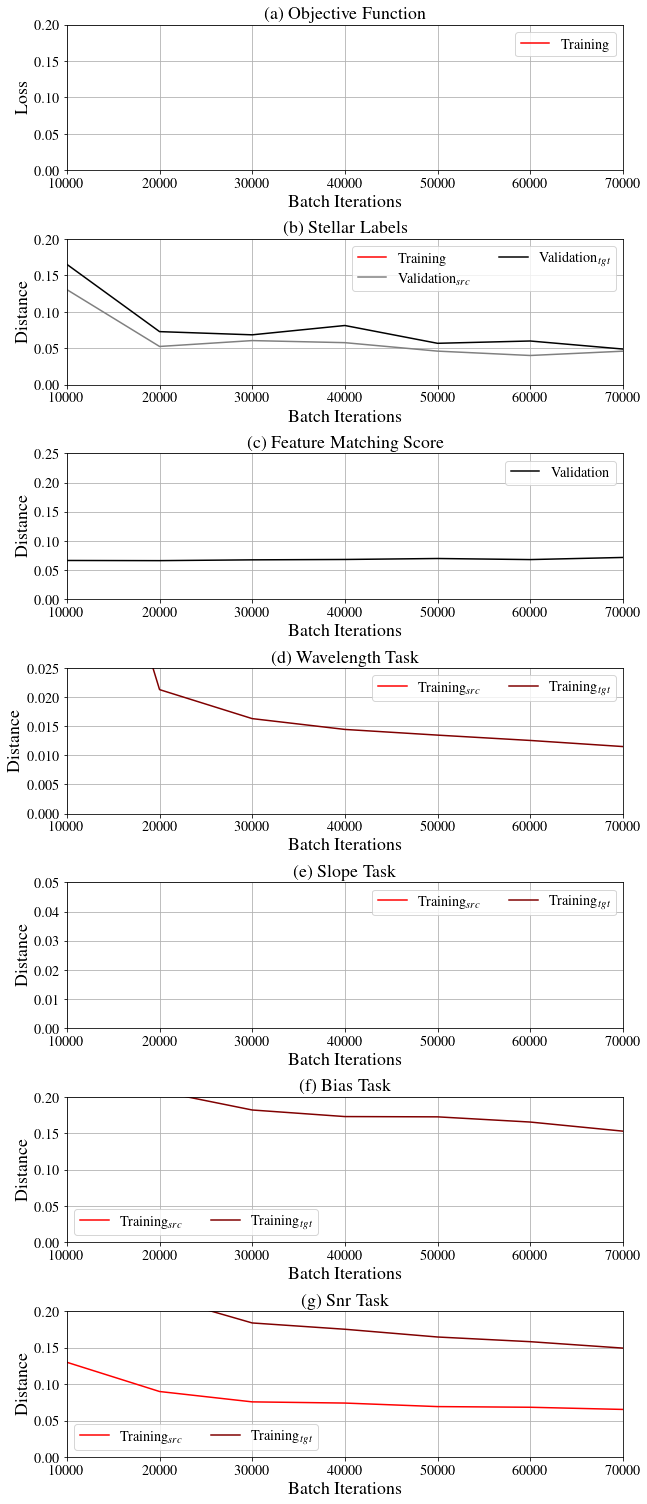

In [2]:
print(model_name)
plot_progress(losses, model.tasks, 
              y_lims=[(0,0.2),(0.,0.2),(0.0,0.25),(0,0.025),(0,0.05),(0,0.2),(0,0.2)])

starnet_ss_234


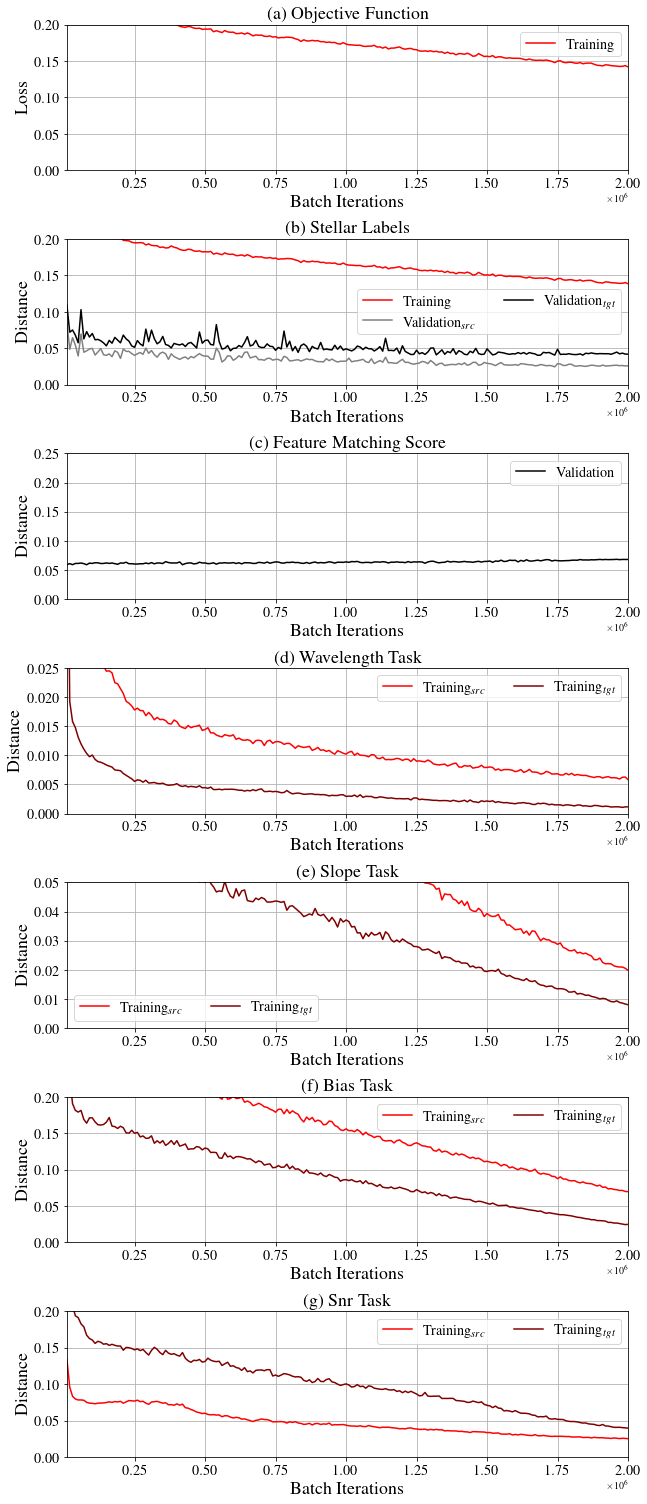

In [2]:
print(model_name)
plot_progress(losses, model.tasks, 
              y_lims=[(0,0.2),(0.,0.2),(0.0,0.25),(0,0.025),(0,0.05),(0,0.2),(0,0.2)])

starnet_ss_79


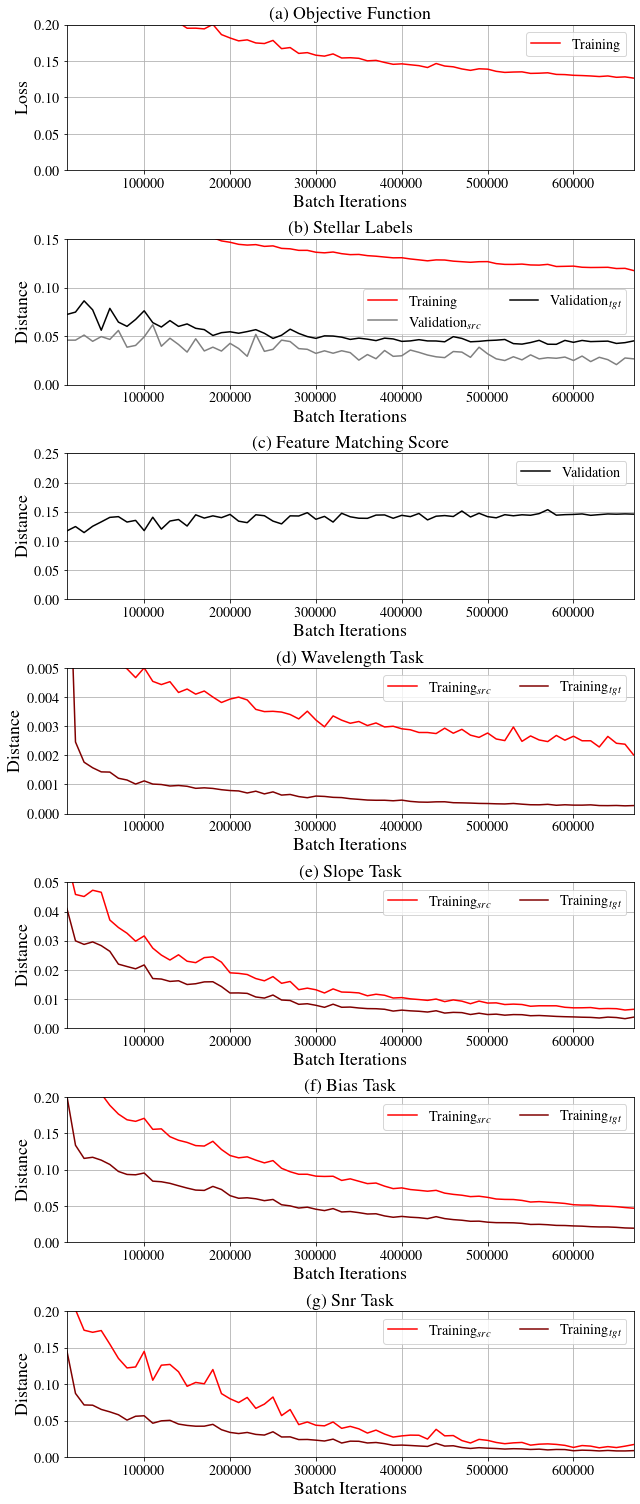

In [10]:
print(model_name)
plot_progress(losses, model.tasks, 
              y_lims=[(0,0.2),(0.,0.15),(0.0,0.25),(0,0.005),(0,0.05),(0,0.2),(0,0.2)])

### **Predict on Source Dataset**

Predicting on 400 spectra...
starnet_ss_1


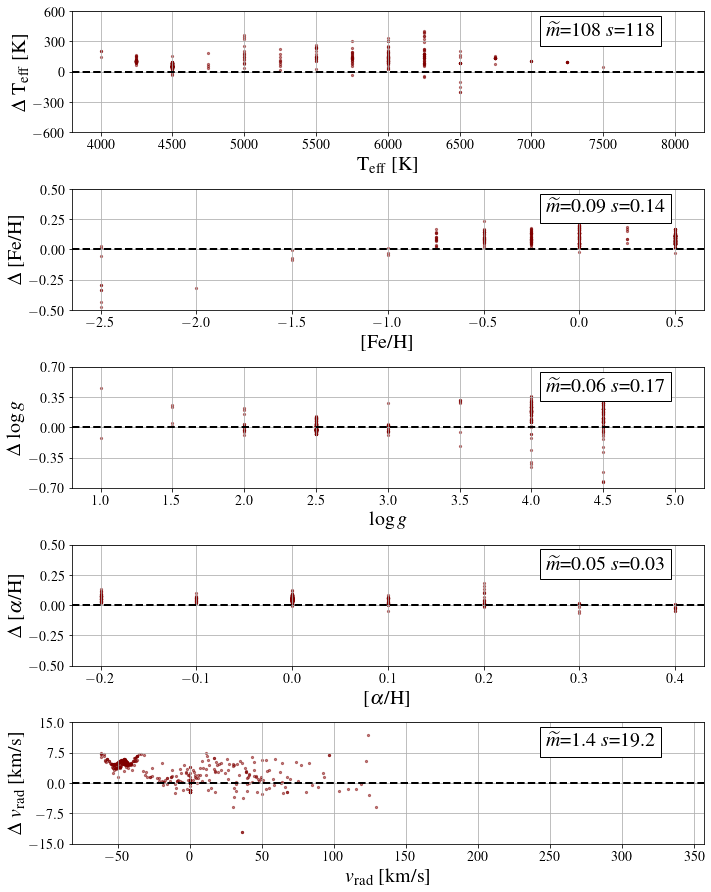

In [3]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, source_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels,
          y_lims = [600, 0.5, 0.7, 0.5, 15])

Predicting on 400 spectra...
starnet_ss_234


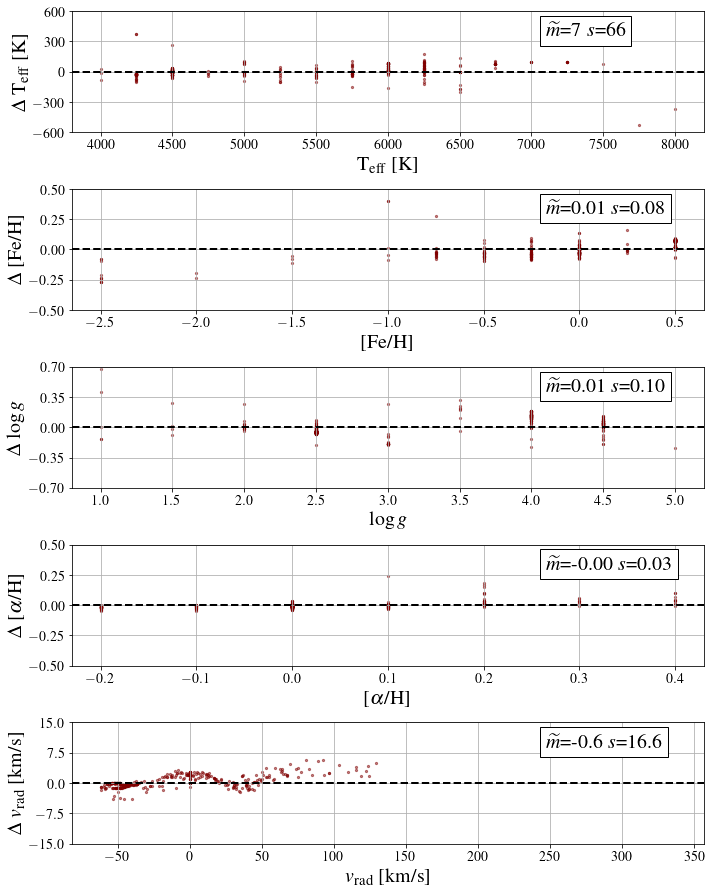

In [3]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, source_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels,
          y_lims = [600, 0.5, 0.7, 0.5, 15])

models/starnet_ss_121.pth.tar

Loading saved model to continue training...
models/starnet_ss_122.pth.tar

Loading saved model to continue training...
models/starnet_ss_123.pth.tar

Loading saved model to continue training...
models/starnet_ss_124.pth.tar

Loading saved model to continue training...
models/starnet_ss_125.pth.tar

Loading saved model to continue training...


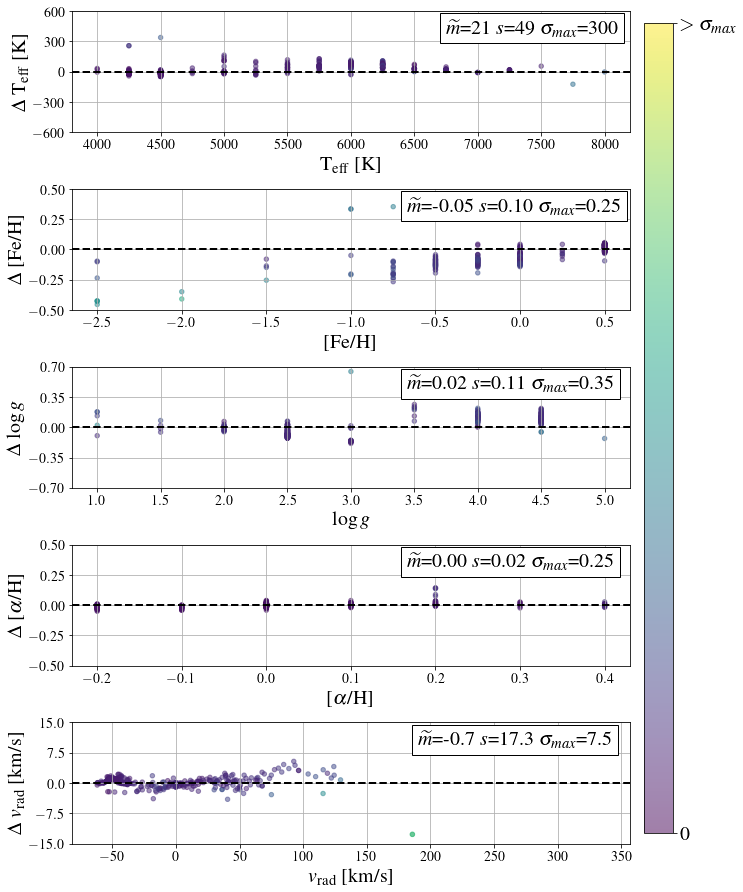

In [4]:
# Load ensemble of models
model_filenames =  [os.path.join(model_dir, 'starnet_ss_%i.pth.tar'%i) for i in range(121,126)]
models = []
for model_filename in model_filenames:
    print(model_filename)
    model, losses, cur_iter = load_model_state(copy.deepcopy(model), model_filename)
    model.eval_mode()
    models.append(model)

(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_ensemble(models, source_val_dataset)

plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, sigma_stellar_labels,
          y_lims=[600, 0.5, 0.7, 0.5, 15], 
           savename='figures/starnet_ss_chunked_ensemble_on_source.png')

models/starnet_ss_105.pth.tar

Loading saved model to continue training...
models/starnet_ss_106.pth.tar

Loading saved model to continue training...
models/starnet_ss_107.pth.tar

Loading saved model to continue training...
models/starnet_ss_108.pth.tar

Loading saved model to continue training...
models/starnet_ss_109.pth.tar

Loading saved model to continue training...
models/starnet_ss_110.pth.tar

Starting fresh model to train...


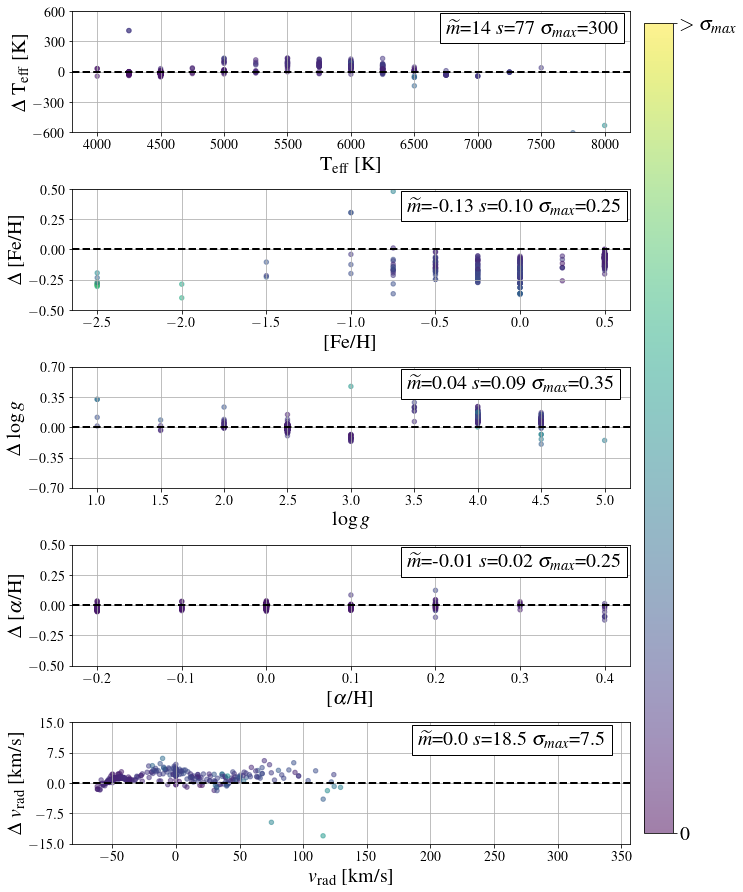

In [5]:
# Load ensemble of models
model_filenames =  [os.path.join(model_dir, 'starnet_ss_%i.pth.tar'%i) for i in range(105,111)]
models = []
for model_filename in model_filenames:
    print(model_filename)
    model, losses, cur_iter = load_model_state(copy.deepcopy(model), model_filename)
    model.eval_mode()
    models.append(model)

(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_ensemble(models, source_val_dataset)

plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, sigma_stellar_labels,
          y_lims=[600, 0.5, 0.7, 0.5, 15], 
           savename='figures/starnet_ss_chunked_ensemble_on_source.png')

### **Predict on Target Dataset**


Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...


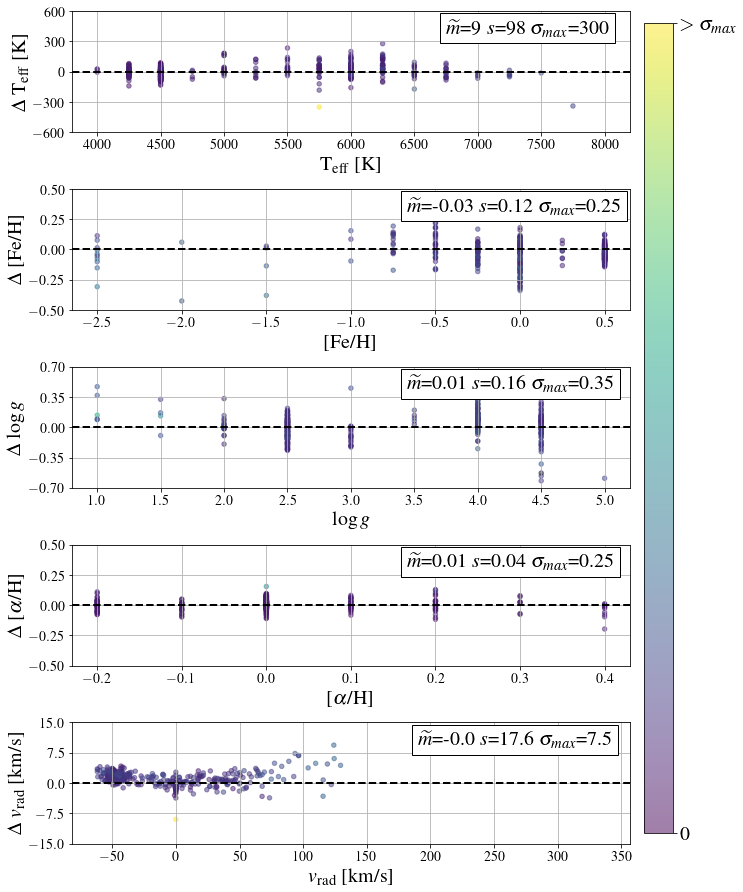

In [5]:
# Load ensemble of models
model_filenames =  [os.path.join(model_dir, 'starnet_ss_%i.pth.tar'%i) for i in range(121,126)]
models = []
for model_filename in model_filenames:
    model, losses, cur_iter = load_model_state(copy.deepcopy(model), model_filename)
    model.eval_mode()
    models.append(model)

(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_ensemble(models, target_val_dataset)

plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, sigma_stellar_labels,
          y_lims=[600, 0.5, 0.7, 0.5, 15], 
           savename='figures/starnet_ss_ensemble_on_target.png')


Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...

Starting fresh model to train...


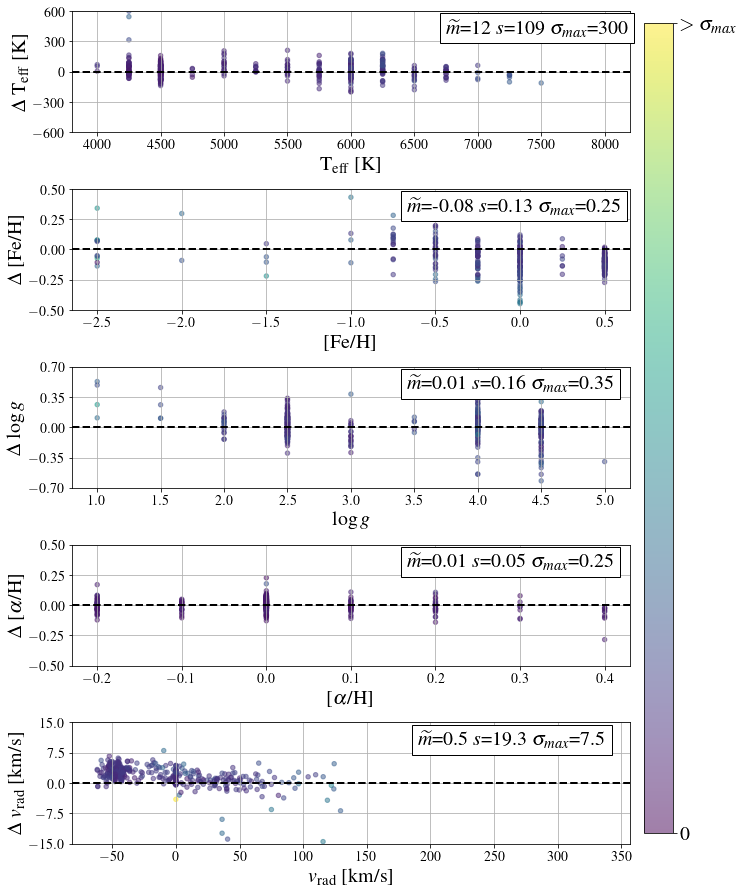

In [6]:
# Load ensemble of models
model_filenames =  [os.path.join(model_dir, 'starnet_ss_%i.pth.tar'%i) for i in range(105,111)]
models = []
for model_filename in model_filenames:
    model, losses, cur_iter = load_model_state(copy.deepcopy(model), model_filename)
    model.eval_mode()
    models.append(model)

(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_ensemble(models, target_val_dataset)

plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, sigma_stellar_labels,
          y_lims=[600, 0.5, 0.7, 0.5, 15], 
           savename='figures/starnet_ss_ensemble_on_target.png')


Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...

Loading saved model to continue training...


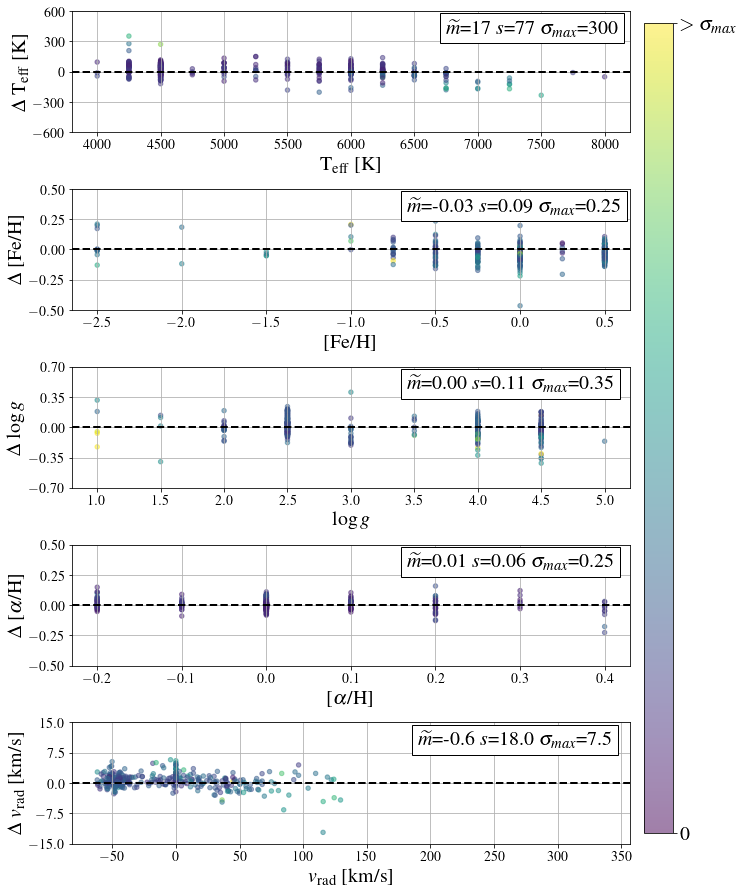

In [32]:
# Load ensemble of models
model_filenames =  [os.path.join(model_dir, 'starnet_ss_%i.pth.tar'%i) for i in range(86,92)]
models = []
for model_filename in model_filenames:
    model, losses, cur_iter = load_model_state(copy.deepcopy(model), model_filename)
    model.eval_mode()
    models.append(model)

(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_ensemble(models, target_val_dataset)

plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, sigma_stellar_labels,
          y_lims=[600, 0.5, 0.7, 0.5, 15], 
           savename='figures/starnet_ss_ensemble_on_target.png')

Predicting on 400 spectra...
starnet_ss_183


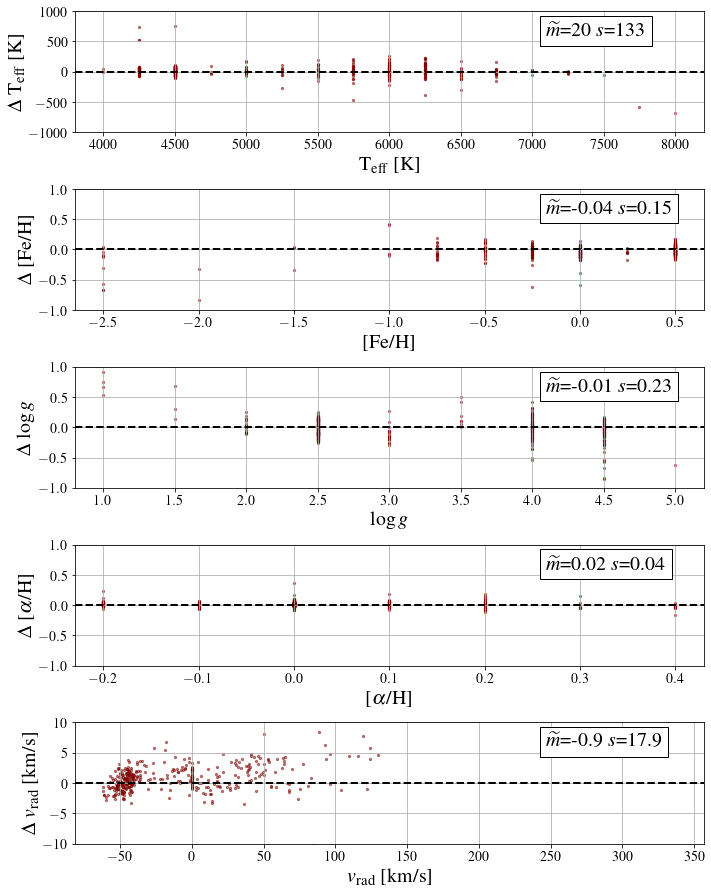

In [4]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels,
          savename='figures/%s_tgt_domain.pdf' % model_name)

Predicting on 400 spectra...
starnet_ss_79


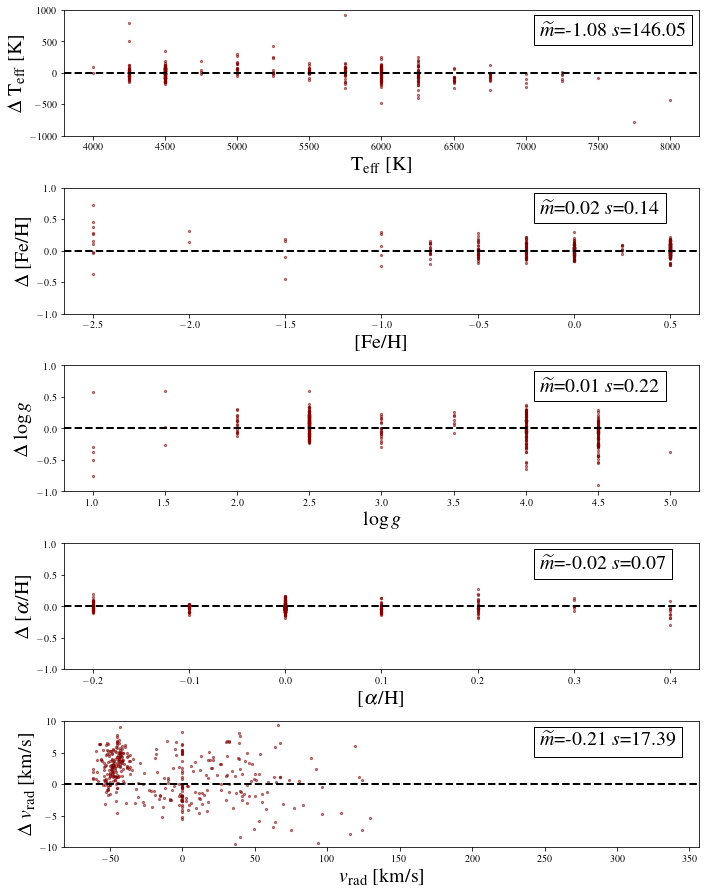

In [12]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc,
          savename='figures/%s_tgt_domain.pdf' % model_name)

In [16]:
torch.nn.TransformerEncoderLayer?

Init signature:
torch.nn.TransformerEncoderLayer(
    d_model,
    nhead,
    dim_feedforward=2048,
    dropout=0.1,
    activation=<function relu at 0x7f532a37e820>,
    layer_norm_eps=1e-05,
    batch_first=False,
    norm_first=False,
    device=None,
    dtype=None,
) -> None
Docstring:     
TransformerEncoderLayer is made up of self-attn and feedforward network.
This standard encoder layer is based on the paper "Attention Is All You Need".
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
in a different way during application.

Args:
    d_model: the number of expected features in the input (required).
    nhead: the number of heads in the multiheadattention models (required).
    dim_feedforward: the dimension of the feedforward network model (default=2048).
    dropout: the

Predicting on 400 spectra...
starnet_ss_81


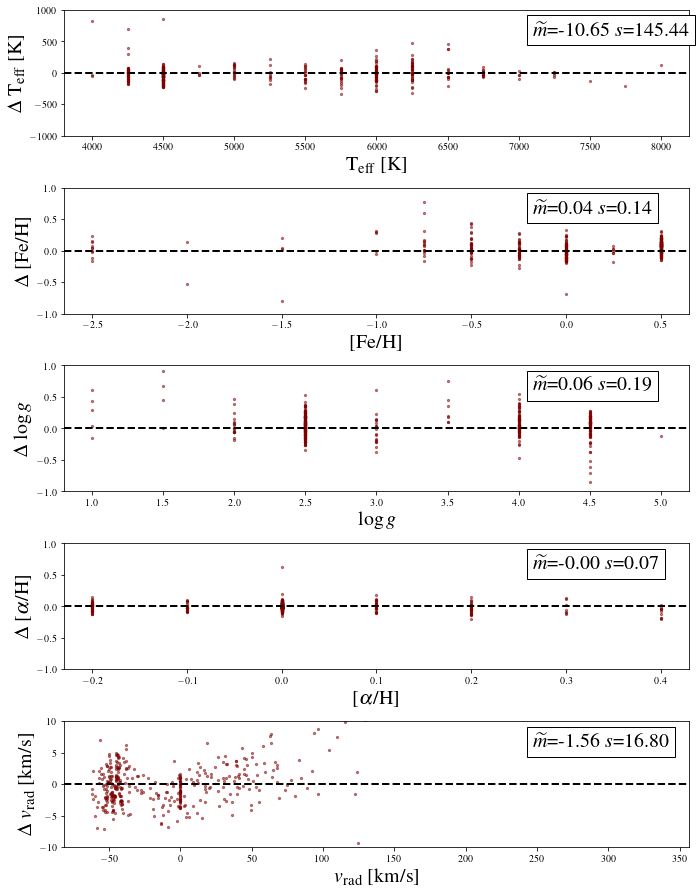

In [6]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc,
          savename='figures/%s_tgt_domain.pdf' % model_name)

Predicting on 400 spectra...
starnet_ss_76


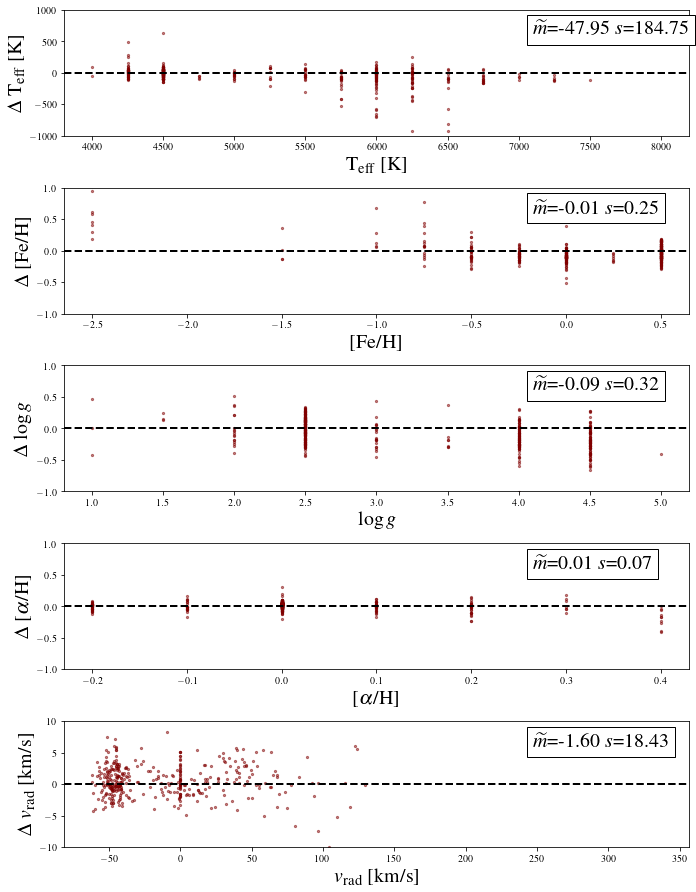

In [7]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc,
          savename='figures/%s_tgt_domain.pdf' % model_name)

Predicting on 400 spectra...
starnet_ss_74


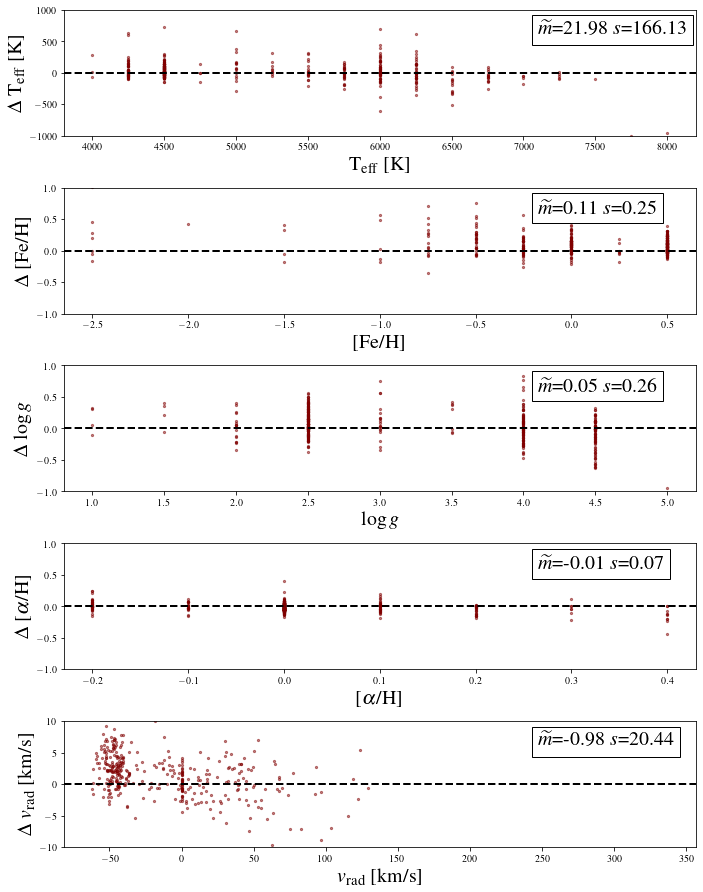

In [2]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc,
          savename='figures/%s_tgt_domain.png' % model_name)

Predicting on 400 spectra...
starnet_ss_71


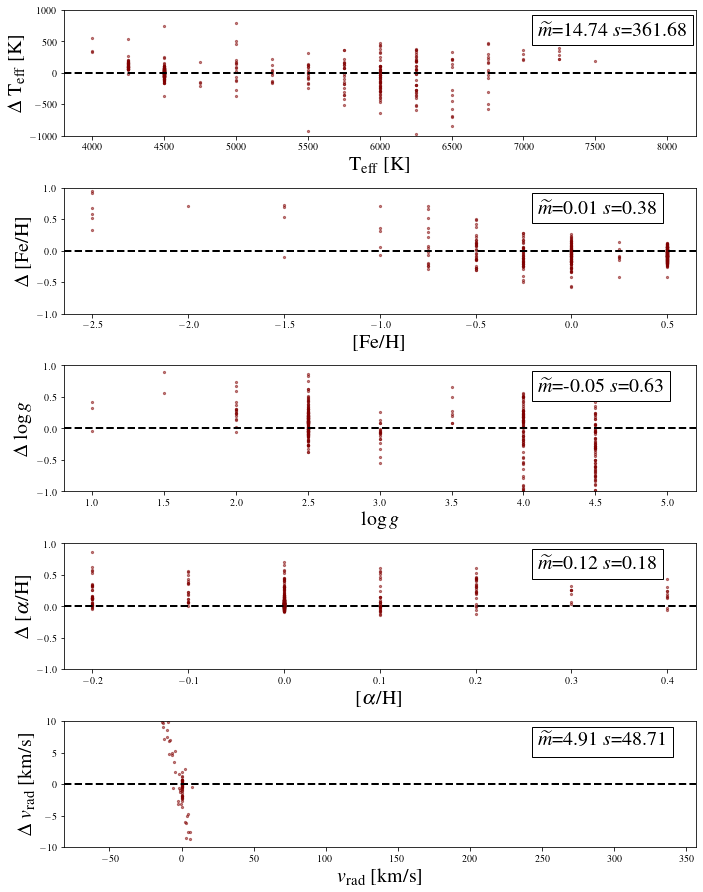

In [4]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)

Predicting on 400 spectra...
starnet_ss_46


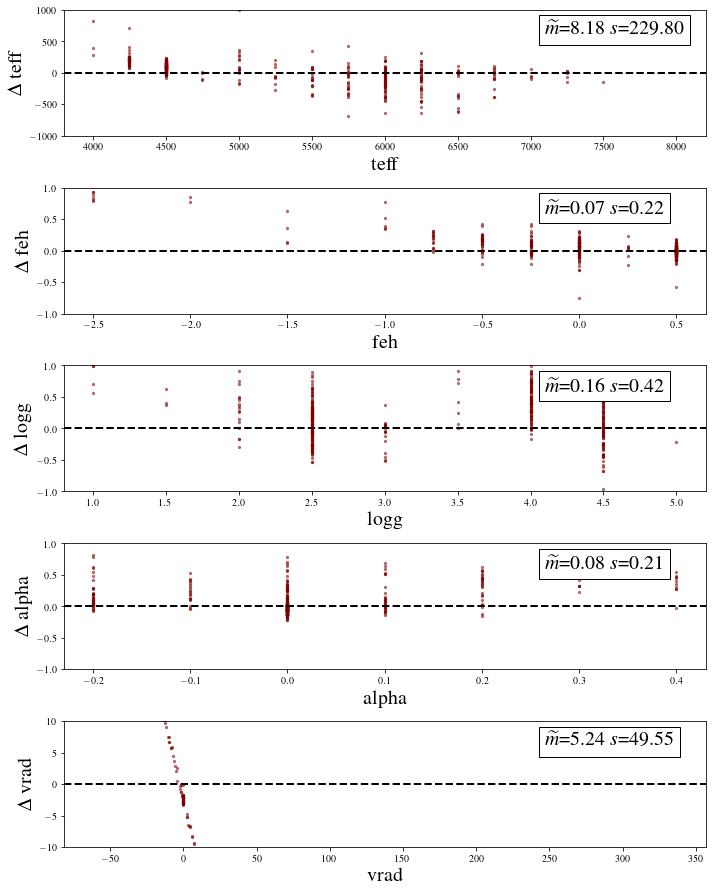

In [8]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)

Predicting on 400 spectra...
starnet_ss_45


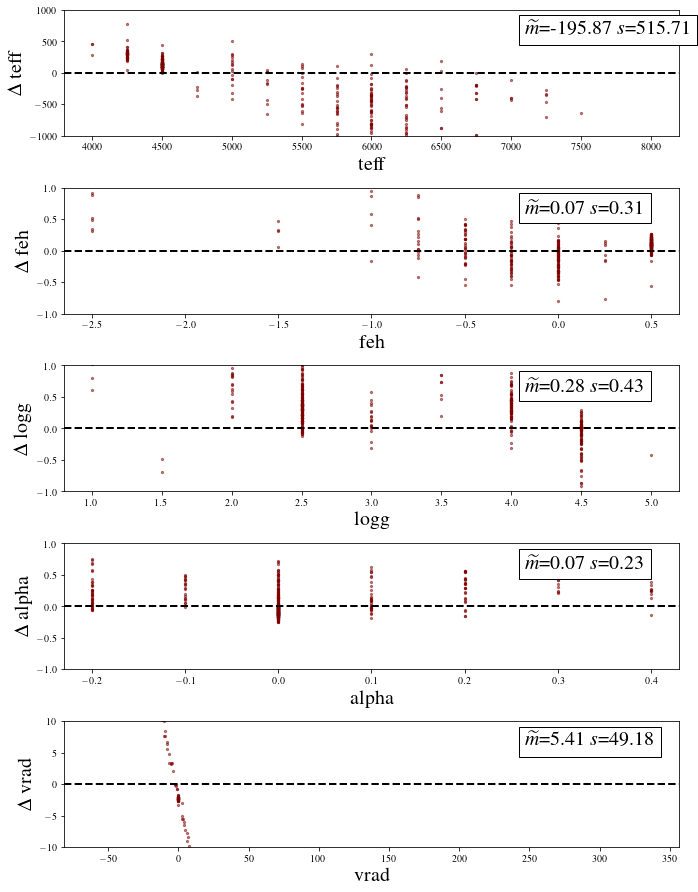

In [4]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)

Predicting on 400 spectra...
starnet_ss_22


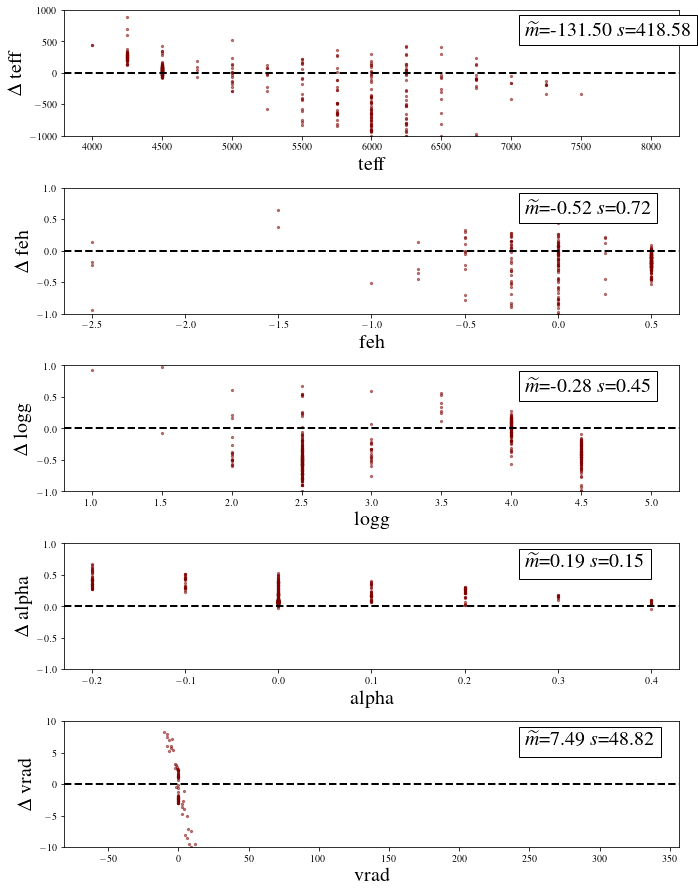

In [27]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)

Predicting on 400 spectra...
starnet_ss_11


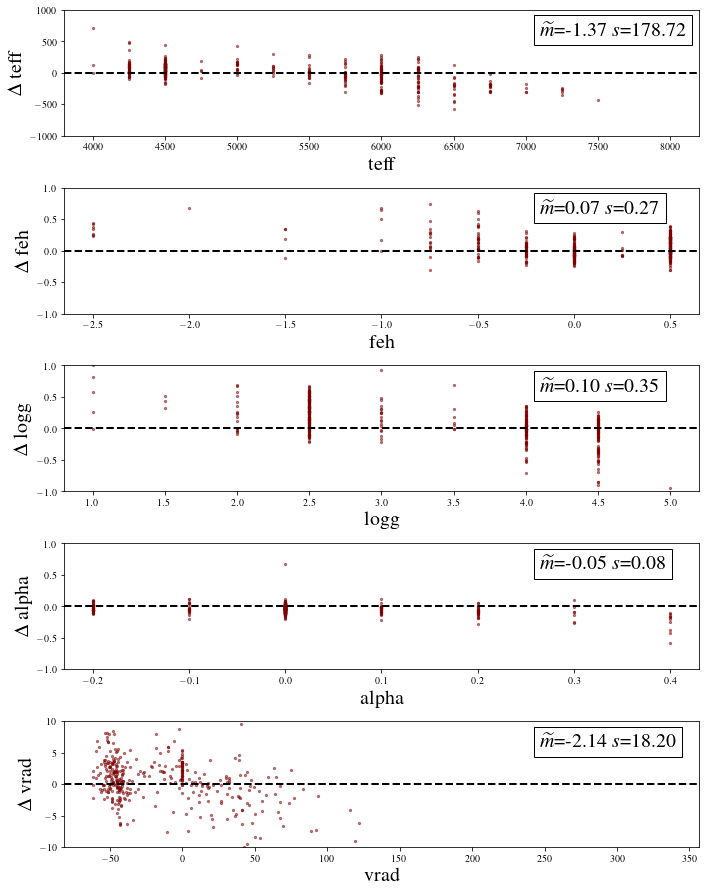

In [5]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)

Predicting on 400 spectra...
starnet_ss_1


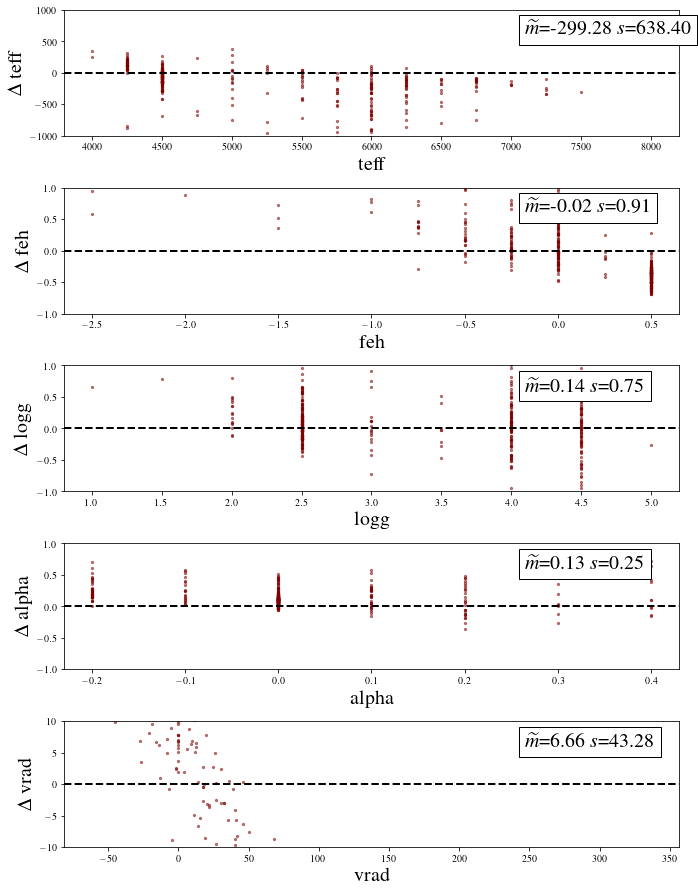

In [9]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)

Predicting on 400 spectra...
starnet_ss_9


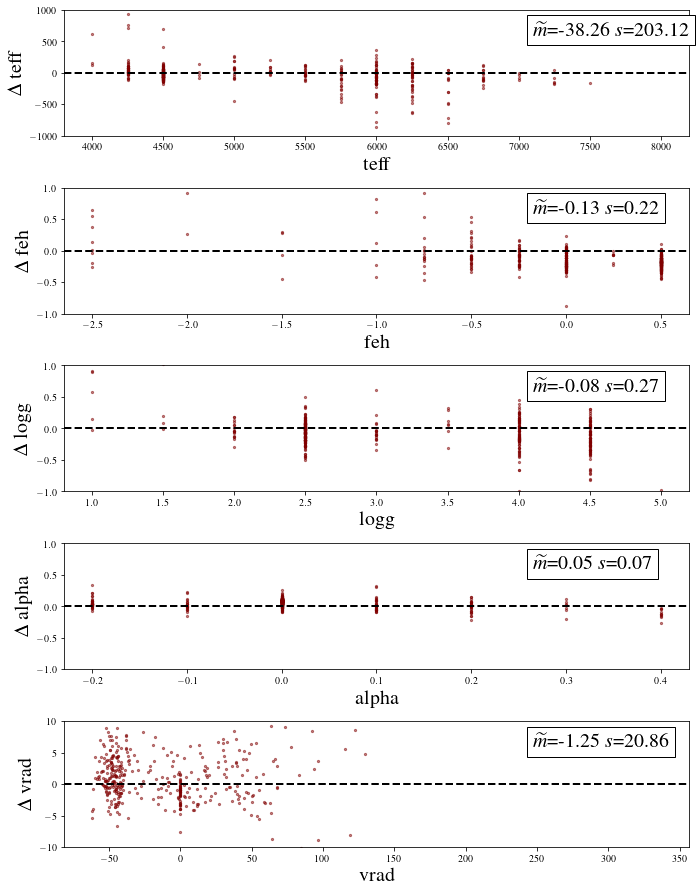

In [7]:
(tgt_stellar_labels, pred_stellar_labels, 
sigma_stellar_labels, tgt_task_labels, 
 pred_task_labels) = predict_labels(model, target_val_dataset)

print(model_name)
plot_resid(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)

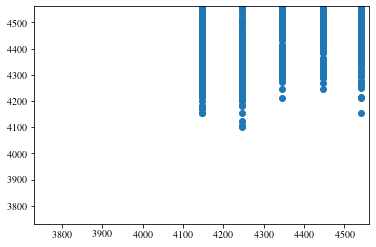

In [30]:
plt.scatter(tgt_task_labels, pred_task_labels[:,0])
plt.xlim(0.9*np.min(tgt_task_labels), 1.1*np.max(tgt_task_labels))
plt.ylim(0.9*np.min(tgt_task_labels), 1.1*np.max(tgt_task_labels))
plt.plot
plt.show()

In [25]:
tgt_task_labels.shape

(5411, 1)

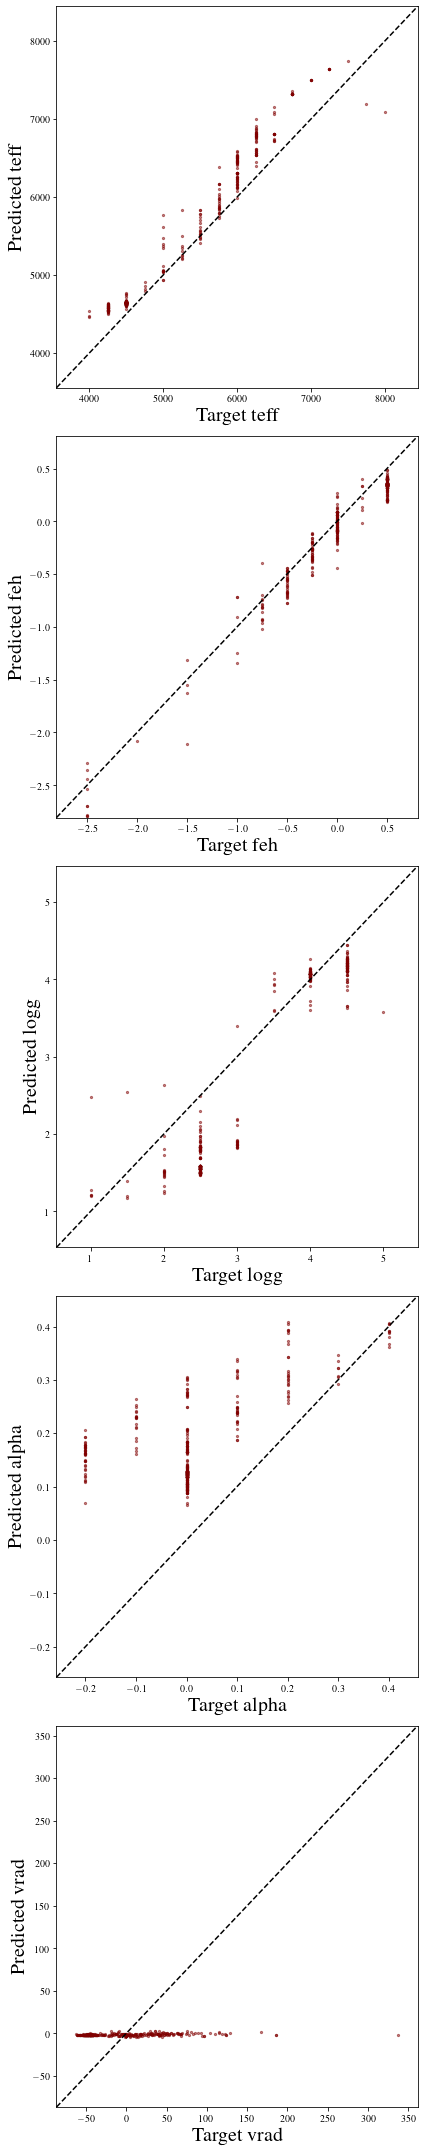

In [5]:
plot_one_to_one(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)

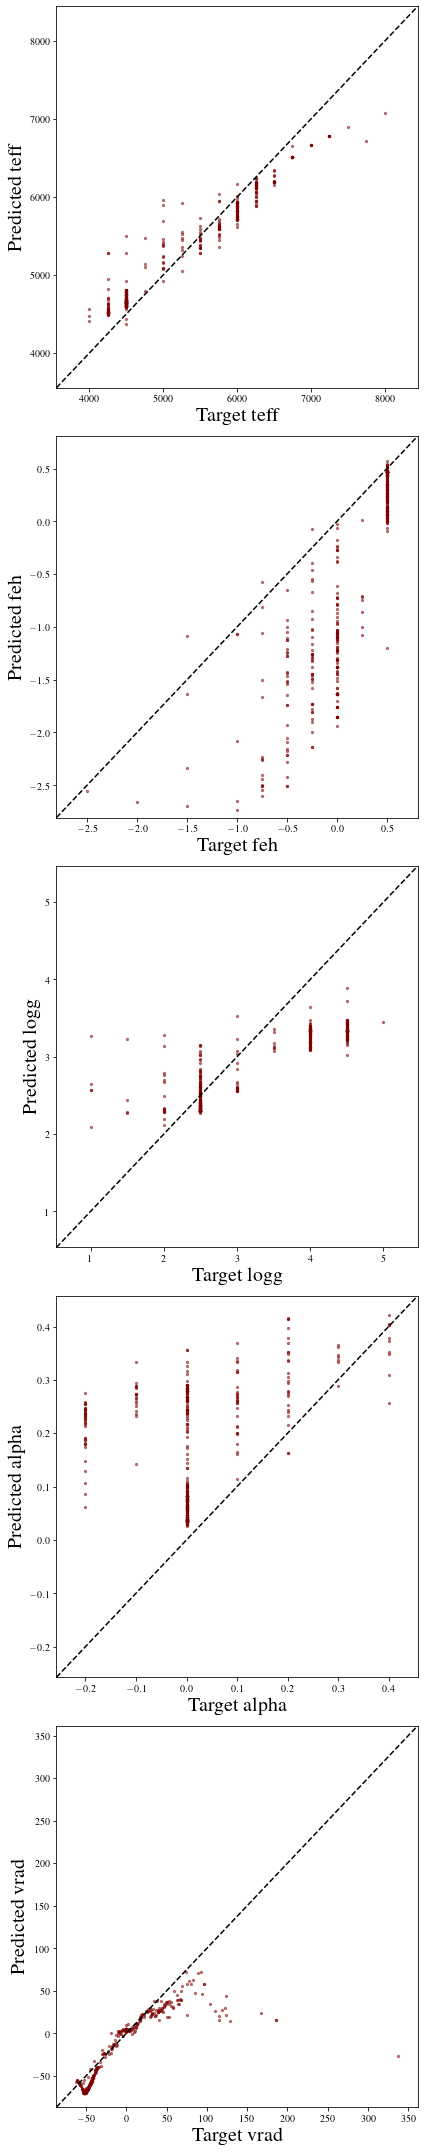

In [4]:
plot_one_to_one(label_keys, tgt_stellar_labels, pred_stellar_labels, model.est_unc)